# 1. Install necessary libraries

In [1]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 9.2 MB/s eta 0:00:00


In [2]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 3.2 MB/s eta 0:00:00


In [3]:
!pip install kmodes

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load the OULAD dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')
# path = '/content/drive/MyDrive/OULAD_analysis/'
path = '/content/drive/MyDrive/IIT Chicago /Coursework /OULAD_analysis/'

Mounted at /content/drive


In [6]:
# path = '/content/drive/MyDrive/OULAD_analysis/'
path = '/content/drive/MyDrive/IIT Chicago /Coursework /OULAD_analysis/'

assessments = pd.read_csv(path + "assessments.csv")

courses = pd.read_csv(path + "courses.csv")

student_assessment = pd.read_csv(path + "studentAssessment.csv")

student_info = pd.read_csv(path + "studentInfo.csv")

student_registration = pd.read_csv(path + "studentRegistration.csv")

student_vle = pd.read_csv(path + "studentVle.csv")

vle = pd.read_csv(path + "vle.csv")

domains=pd.DataFrame(
    {
        "code_module": ["AAA", "BBB", "CCC", "DDD", "EEE", "FFF", "GGG"],
        "domain": [
            "Social Sciences",
            "Social Sciences",
            "STEM",
            "STEM",
            "STEM",
            "STEM",
            "Social Sciences",
        ],
    },
)

In [7]:
# Handling weights for module GGG
assessments.loc[(assessments['code_module']=='GGG') & (assessments['weight']==0), 'weight'] = 11.11
# Handling weights for module FFF
assessments.loc[(assessments['code_module']=='FFF') & (assessments['weight']==0), 'weight'] = 14.29

In [8]:
## create % of on-time submissions feature in next iteration
assessmentsCombinedDf = student_assessment.merge(assessments, on=['id_assessment'])

assessmentsCombinedDf['weighted_score'] = assessmentsCombinedDf['score'] * assessmentsCombinedDf['weight'] / 100
assessmentsCombinedDf['sum_weighted_score'] = assessmentsCombinedDf.groupby(["code_module","code_presentation","id_student"])['weighted_score'].transform('sum')
assessmentsCombinedDf['sum_weight'] = assessmentsCombinedDf.groupby(["code_module","code_presentation","id_student"])['weight'].transform('sum')

assessmentsCombinedDf['OntimeSubmission'] = np.where(assessmentsCombinedDf["date_submitted"] <= assessmentsCombinedDf["date"], 1, 0)
assessmentsCombinedDf['ontime_sum'] = assessmentsCombinedDf.groupby(["code_module","code_presentation","id_student"])['OntimeSubmission'].transform('sum')
assessmentsCombinedDf['ontime_count'] = assessmentsCombinedDf.groupby(["code_module","code_presentation","id_student"])['OntimeSubmission'].transform('count')

assessmentsCombinedDf = assessmentsCombinedDf.groupby(['code_module','code_presentation','id_student'], as_index=False).last()
assessmentsCombinedDf['final_weighted_score'] = assessmentsCombinedDf['sum_weighted_score'] / assessmentsCombinedDf['sum_weight']
assessmentsCombinedDf["perc_ontime_sub"] = assessmentsCombinedDf['ontime_sum'] / assessmentsCombinedDf['ontime_count']

assessmentsCombinedDf.drop(["id_assessment", "score", "date", "weight", "weighted_score", "sum_weighted_score",
                            "sum_weight", "OntimeSubmission", "ontime_sum", "ontime_count", "date_submitted",
                            "assessment_type"], axis=1, inplace=True)

In [9]:
vleCombinedDf = student_vle.merge(vle, on=['code_module','code_presentation', 'id_site']).drop(['week_from', 'week_to'], axis=1)
vleCombinedDf['avgClicksPerDay'] = (vleCombinedDf.groupby(['code_module','code_presentation','id_student'])['sum_click']
                                    .transform('mean'))
vleCombinedDf = vleCombinedDf.groupby(['code_module','code_presentation','id_student'], as_index=False).first()
vleCombinedDf.drop(["id_site", "date", "activity_type", "sum_click"], axis=1, inplace=True)

In [166]:
std_reg_courses = student_registration.merge(courses, on=["code_module","code_presentation"])
std_reg_courses_domain = std_reg_courses.merge(domains, on="code_module")
# std_reg_courses_domain.drop(['date_registration','date_unregistration'], axis=1, inplace=True)
# std_reg_courses_domain.head()

In [170]:
std_info_reg_courses_domain = student_info.merge(std_reg_courses_domain, on=["code_module", "code_presentation", "id_student"])
std_info_reg_courses_domain_vle = std_info_reg_courses_domain.merge(vleCombinedDf, on=["code_module", "code_presentation", "id_student"])
finalCombinedDf = std_info_reg_courses_domain_vle.merge(assessmentsCombinedDf, on=["code_module", "code_presentation", "id_student"])
# finalCombinedDf.head()

In [187]:
finalCombinedDf.final_result.value_counts()

final_result
Pass           12356
Fail            5740
Withdrawn       4673
Distinction     3024
Name: count, dtype: int64

In [179]:
finalCombinedDf[finalCombinedDf.final_result == "Withdrawn"]['final_result'].value_counts()

final_result
Withdrawn    4673
Name: count, dtype: int64

In [180]:
finalCombinedDf[finalCombinedDf.final_result == "Withdrawn"].isna().sum()

code_module                     0
code_presentation               0
id_student                      0
gender                          0
region                          0
highest_education               0
imd_band                      139
age_band                        0
num_of_prev_attempts            0
studied_credits                 0
disability                      0
final_result                    0
date_registration               4
date_unregistration            21
module_presentation_length      0
domain                          0
avgClicksPerDay                 0
is_banked                       0
final_weighted_score          126
perc_ontime_sub                 0
dtype: int64

In [186]:
finalCombinedDf[finalCombinedDf.final_result == "Withdrawn"][['date_unregistration']].value_counts().to_excel("results.xlsx")

<Axes: ylabel='Frequency'>

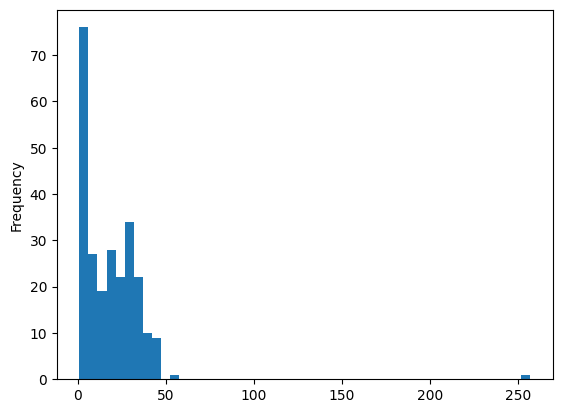

In [183]:
finalCombinedDf[finalCombinedDf.final_result == "Withdrawn"][['date_unregistration']].value_counts().plot.hist(bins=50)

In [12]:
finalCombinedDf.loc[(finalCombinedDf.final_weighted_score.isna()), 'final_weighted_score'] = 0
finalCombinedDf.loc[(finalCombinedDf.imd_band.isna()), 'imd_band'] = '50-60%'

In [13]:
# demographics cluster
from kmodes.kprototypes import KPrototypes

cluster_stdInfo = finalCombinedDf.copy()

# Assume df is already loaded and contains the required columns
categorical_columns = ['gender', 'highest_education', 'imd_band', 'age_band', 'disability', 'region']
numerical_columns = ['num_of_prev_attempts', 'studied_credits']

# Convert categorical columns to category dtypes
for col in categorical_columns:
    cluster_stdInfo[col] = cluster_stdInfo[col].astype('category')

# Creating a copy of the data for clustering that excludes the key columns
cluster_stdInfo = cluster_stdInfo[categorical_columns + numerical_columns].copy()
cluster_stdInfo[categorical_columns] = cluster_stdInfo[categorical_columns].apply(lambda x: x.cat.codes)

# Convert the DataFrame to a NumPy array
data_matrix = cluster_stdInfo.to_numpy()

kproto = KPrototypes(n_clusters=5, init='Cao', n_init=5, verbose=1)

clusters = kproto.fit_predict(data_matrix, categorical=[cluster_stdInfo.columns.get_loc(c) for c in categorical_columns])

finalCombinedDf['demographic_cluster'] = clusters


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 3110, ncost: 4445833.363369736
Run: 1, iteration: 2/100, moves: 1029, ncost: 4445754.886440184
Run: 1, iteration: 3/100, moves: 169, ncost: 4445715.104440441
Run: 1, iteration: 4/100, moves: 0, ncost: 4445715.104440441
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 663, ncost: 9438166.144720286
Run: 2, iteration: 2/100, moves: 1, ncost: 9438166.07698618
Run: 2, iteration: 3/100, moves: 0, ncost: 9438166.07698618
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/

<Axes: ylabel='count'>

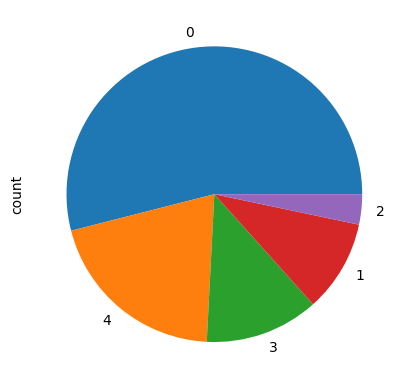

In [14]:
finalCombinedDf.demographic_cluster.value_counts().plot.pie()

In [15]:
finalCombinedDf.demographic_cluster.value_counts(dropna=0)

demographic_cluster
0    13922
4     5211
3     3213
1     2594
2      853
Name: count, dtype: int64

In [16]:
# behavioural cluster
from sklearn.cluster import KMeans

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
finalCombinedDf['behavioural_cluster'] = kmeans.fit_predict(finalCombinedDf[['avgClicksPerDay']])

In [17]:
# assesments cluster
finalCombinedDf['assesments_cluster'] = kmeans.fit_predict(finalCombinedDf[['perc_ontime_sub',
                                                                            'final_weighted_score']])


In [18]:
finalCombinedDf.columns

Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result',
       'module_presentation_length', 'domain', 'avgClicksPerDay', 'is_banked',
       'final_weighted_score', 'perc_ontime_sub', 'demographic_cluster',
       'behavioural_cluster', 'assesments_cluster'],
      dtype='object')

In [19]:
pivot_std_vle = student_vle.pivot_table(
                    index=['id_student','code_module','code_presentation'],
                    columns='date',
                    values='sum_click',
                    aggfunc='sum',
                    fill_value = 0
                )
pivot_std_vle.head()

date                                      -25   -24   -23   -22   -21   -20   \
id_student code_module code_presentation                                       
6516       AAA         2014J                 0     0    28    82     0    41   
8462       DDD         2013J                 0     0     0     0     0     0   
                       2014J                 0     0     0     0     0     0   
11391      AAA         2013J                 0     0     0     0     0     0   
23629      BBB         2013B                 0     0     0     0     0     0   

date                                      -19   -18   -17   -16   ...   260  \
id_student code_module code_presentation                          ...         
6516       AAA         2014J                 0     0     7     0  ...     0   
8462       DDD         2013J                 0     0     0     0  ...     0   
                       2014J                 0     0     0     0  ...     0   
11391      AAA         2013J                 0     0     0     0  ...     0   
23629      BBB         2013B                 0     0     0     0  ...     0   

date                                       261   262   263   264   265   266  \
id_student code_module code_presentation                                       
6516       AAA         2014J                 0     0     0     0     0     0   
8462       DDD         2013J                 0     0     0     0     0     0   
                       2014J                 0     0     0     0     0     0   
11391      AAA         2013J                 0     0     0     0     0     0   
23629      BBB         2013B                 0     0     0     0     0     0   

date                                       267   268   269  
id_student code_module code_presentation                    
6516       AAA         2014J                 0     1     1  
8462       DDD         2013J                 0     0     0  
                       2014J                 0     0     0  
11391      AAA         2013J                 0     0     0  
23629      BBB         2013B                 0     0     0  

[5 rows x 295 columns]

In [20]:
finalCombinedDf = finalCombinedDf.merge(pivot_std_vle, on =['id_student','code_module','code_presentation'])
finalCombinedDf.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,260,261,262,263,264,265,266,267,268,269
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,0,0,0,0,0,0,0,0,0,0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,0,0,0,0,0,0,0,0,0,0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,0,1,0,0,1,0,0,0,0,0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,0,0,0,0,0,0,0,0,0,0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,...,0,1,1,0,1,2,0,1,0,0


In [21]:
finalCombinedDf.shape

(25793, 316)

In [22]:
# # Encoding
# def OrdMapping(df):

#     imd_band_mapping = {'0-10%': 0,'10-20': 1,'20-30%': 2 , '30-40%':3,'40-50%': 4, '50-60%':5, '60-70%':6, '70-80%':7, '80-90%':8, '90-100%':9 }
#     highest_education_mapping= {'No Formal quals':0, 'Lower Than A Level':2, 'A Level or Equivalent':3, 'HE Qualification':4,'Post Graduate Qualification':5}

#     df['imd_band'] = df.imd_band.map(imd_band_mapping)
#     df['highest_education'] = df.highest_education.map(highest_education_mapping)

#     return df

# ordinal_features = ['imd_band','highest_education']
# nominal_features = ['code_module','code_presentation','gender','region','age_band','disability']

# # ordinal encoding
# ordMapped_df = OrdMapping(finalCombinedDf).copy()

# # One hot encoding
# onehotEncoded_df = pd.get_dummies(ordMapped_df, columns=nominal_features, drop_first=True, dtype=float)

In [23]:
# onehotEncoded_df.shape

In [24]:
# target variable creation
onehotEncoded_df = finalCombinedDf.copy()
onehotEncoded_df['isDropout'] = np.where(onehotEncoded_df["final_result"] == "Withdrawn", 1, 0)
onehotEncoded_df.isDropout.value_counts()

isDropout
0    21120
1     4673
Name: count, dtype: int64

<Axes: ylabel='count'>

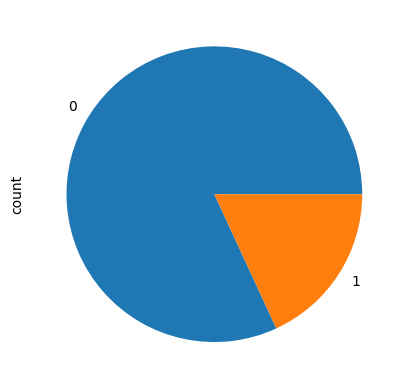

In [25]:
onehotEncoded_df.isDropout.value_counts().plot.pie()

In [26]:
onehotEncoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25793 entries, 0 to 25792
Columns: 317 entries, code_module to isDropout
dtypes: float64(3), int32(2), int64(301), object(10), uint16(1)
memory usage: 62.0+ MB


In [27]:
onehotEncoded_df.describe()

,id_student,num_of_prev_attempts,studied_credits,module_presentation_length,avgClicksPerDay,is_banked,final_weighted_score,perc_ontime_sub,demographic_cluster,behavioural_cluster,...,261,262,263,264,265,266,267,268,269,isDropout
count,2.579300e+04,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,...,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000,25793.000000
mean,7.085493e+05,0.155120,76.778389,256.123406,3.363473,0.009460,0.700663,0.685846,1.348544,2.141124,...,0.180359,0.154461,0.121351,0.128562,0.103051,0.064940,0.076610,0.117008,0.058117,0.181173
std,5.543334e+05,0.465895,38.286432,13.142867,1.171479,0.096803,0.175717,0.329001,1.663735,1.621696,...,1.367563,1.786124,2.469511,1.973495,1.041145,0.971808,1.012113,1.068796,1.321320,0.385169
min,6.516000e+03,0.000000,30.000000,234.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.057220e+05,0.000000,60.000000,241.000000,2.465587,0.000000,0.610000,0.444444,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.892950e+05,0.000000,60.000000,262.000000,3.195402,0.000000,0.732400,0.800000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.428830e+05,0.000000,90.000000,268.000000,4.070225,0.000000,0.827200,1.000000,3.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.698588e+06,6.000000,630.000000,269.000000,20.028933,1.000000,1.000000,1.000000,4.000000,4.000000,...,52.000000,187.000000,363.000000,197.000000,42.000000,75.000000,55.000000,43.000000,186.000000,1.000000


In [28]:
onehotEncoded_df.columns

Index([         'code_module',    'code_presentation',           'id_student',
                     'gender',               'region',    'highest_education',
                   'imd_band',             'age_band', 'num_of_prev_attempts',
            'studied_credits',
       ...
                          261,                    262,                    263,
                          264,                    265,                    266,
                          267,                    268,                    269,
                  'isDropout'],
      dtype='object', length=317)

In [29]:
onehotEncoded_df.isna().sum().sum()

0

In [30]:
pivot_df = onehotEncoded_df.copy()

# 3. Train-Test split

<Axes: xlabel='isDropout', ylabel='count'>

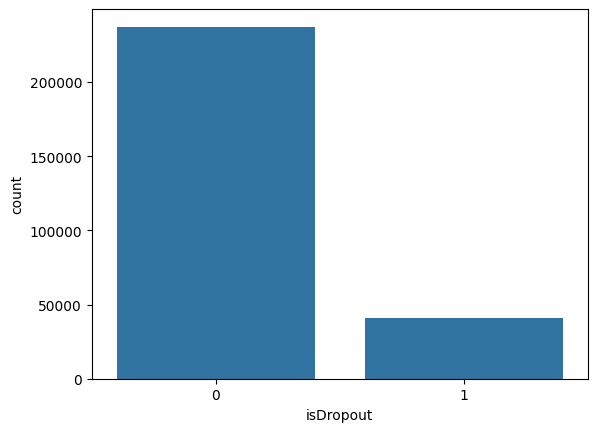

In [31]:
sns.countplot(x='isDropout', data=pivot_df)

In [32]:
pivot_df['isDropout'].value_counts()

isDropout
0    21120
1     4673
Name: count, dtype: int64

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X = pivot_df.drop(['id_student','code_module','code_presentation','highest_education',
                   'imd_band', 'num_of_prev_attempts', 'studied_credits',
                   'module_presentation_length', 'is_banked', 'gender', 'region',
                   'age_band', 'disability','isDropout','final_result', 'domain'], axis=1)
y = pivot_df['isDropout'].values  # target variable

In [35]:
X.columns.astype(str)

Index(['avgClicksPerDay', 'final_weighted_score', 'perc_ontime_sub',
       'demographic_cluster', 'behavioural_cluster', 'assesments_cluster',
       '-25', '-24', '-23', '-22',
       ...
       '260', '261', '262', '263', '264', '265', '266', '267', '268', '269'],
      dtype='object', length=301)

In [36]:
X.columns = X.columns.astype(str)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [38]:
print(X.shape)
print(y.shape)

(25793, 301)
(25793,)


In [39]:
print(X_train.shape)
print(y_train.shape)

(19344, 301)
(19344,)


In [40]:
print(X_test.shape)
print(y_test.shape)

(6449, 301)
(6449,)


In [41]:
X_train.head()

,avgClicksPerDay,final_weighted_score,perc_ontime_sub,demographic_cluster,behavioural_cluster,assesments_cluster,-25,-24,-23,-22,...,260,261,262,263,264,265,266,267,268,269
22633,2.932292,0.545000,0.666667,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5144,2.427835,0.733333,0.333333,2,3,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14117,2.606838,0.620000,0.428571,0,3,0,4,0,3,0,...,0,0,0,0,0,0,0,0,0,0
12536,2.934426,0.292500,0.800000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14658,1.753555,0.352500,0.714286,0,3,1,0,61,1,1,...,0,0,0,0,0,0,0,0,0,0


In [42]:
y_train

array([0, 1, 0, ..., 0, 0, 0])

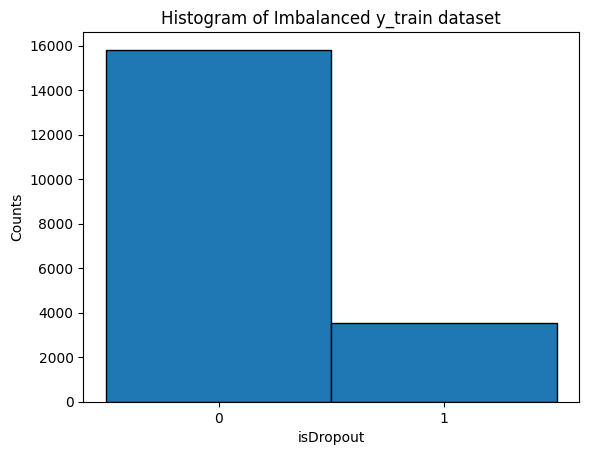

In [43]:
plt.hist(y_train, bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0, 1])
plt.xlabel('isDropout')
plt.ylabel('Counts')
plt.title('Histogram of Imbalanced y_train dataset')
plt.show()

In [45]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 1.5 MB/s eta 0:00:00


In [46]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# SMOTE(Synthetic Minority Oversampling Technique) is an oversampling technique where the synthetic samples are generated for the minority class.

In [47]:
X_train_balanced.shape

(31638, 301)

In [48]:
y_train_balanced.shape

(31638,)

In [49]:
y_train_balanced

array([0, 1, 0, ..., 1, 1, 1])

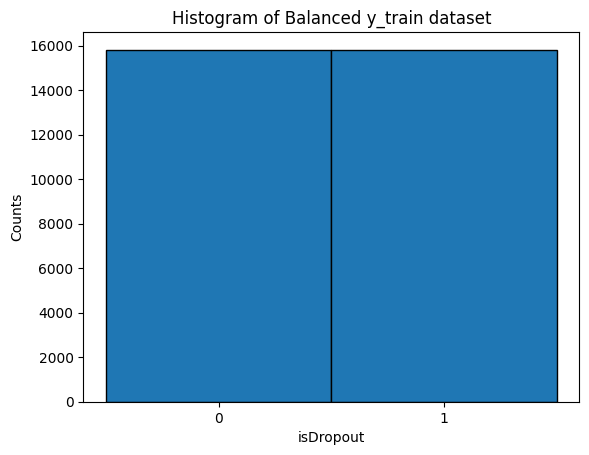

In [50]:
plt.hist(y_train_balanced, bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0, 1])
plt.xlabel('isDropout')
plt.ylabel('Counts')
plt.title('Histogram of Balanced y_train dataset')
plt.show()

In [51]:
X_train_balanced.head()

,avgClicksPerDay,final_weighted_score,perc_ontime_sub,demographic_cluster,behavioural_cluster,assesments_cluster,-25,-24,-23,-22,...,260,261,262,263,264,265,266,267,268,269
0,2.932292,0.545000,0.666667,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.427835,0.733333,0.333333,2,3,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.606838,0.620000,0.428571,0,3,0,4,0,3,0,...,0,0,0,0,0,0,0,0,0,0
3,2.934426,0.292500,0.800000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.753555,0.352500,0.714286,0,3,1,0,61,1,1,...,0,0,0,0,0,0,0,0,0,0


In [52]:
y_train_balanced

array([0, 1, 0, ..., 1, 1, 1])

In [53]:
X_train_balanced.columns

Index(['avgClicksPerDay', 'final_weighted_score', 'perc_ontime_sub',
       'demographic_cluster', 'behavioural_cluster', 'assesments_cluster',
       '-25', '-24', '-23', '-22',
       ...
       '260', '261', '262', '263', '264', '265', '266', '267', '268', '269'],
      dtype='object', length=301)

Train-test split (TSF)

In [54]:
X_train_ts = X_train_balanced.drop(['avgClicksPerDay', 'final_weighted_score', 'perc_ontime_sub',
                                    'demographic_cluster', 'behavioural_cluster', 'assesments_cluster'], axis=1)

In [55]:
X_train_ts.head()

,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,...,260,261,262,263,264,265,266,267,268,269
0,0,0,0,0,0,0,0,2,4,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,3,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,61,1,1,0,1,7,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
y_train_ts = y_train_balanced

In [57]:
X_test_ts = X_test.drop(['avgClicksPerDay', 'final_weighted_score', 'perc_ontime_sub',
                         'demographic_cluster', 'behavioural_cluster', 'assesments_cluster'], axis=1)

In [58]:
y_test_ts = y_test

In [59]:
print(X_train_ts.shape)
print(y_train_ts.shape)
print(X_test_ts.shape)
print(y_test_ts.shape)

(31638, 295)
(31638,)
(6449, 295)
(6449,)


Train-test split: Demographic data

In [60]:
X_train_demo = X_train_balanced[['avgClicksPerDay', 'final_weighted_score', 'perc_ontime_sub',
                         'demographic_cluster', 'behavioural_cluster', 'assesments_cluster']]

In [61]:
X_test_demo = X_test[['avgClicksPerDay', 'final_weighted_score', 'perc_ontime_sub',
                         'demographic_cluster', 'behavioural_cluster', 'assesments_cluster']]

In [62]:
y_train_demo = y_train_balanced

In [63]:
y_test_demo = y_test

In [64]:
print(X_train_demo.shape)
print(y_train_demo.shape)
print(X_test_demo.shape)
print(y_test_demo.shape)

(31638, 6)
(31638,)
(6449, 6)
(6449,)


# 5. Data Modeling (TSF + RF = Meta-model)

## 5.1) Time Series data (Interactive data) - Time Series Forest model (TSF)

In [65]:
X_train_tsf = X_train_ts.values.reshape((X_train_ts.shape[0], 1, X_train_ts.shape[1]))
X_test_tsf = X_test_ts.values.reshape((X_test_ts.shape[0], 1, X_test_ts.shape[1]))

In [66]:
X_train_tsf

array([[[0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0]],

       [[4, 0, 3, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0]]])

In [67]:
y_train_tsf = pd.Series(y_train_ts)
y_test_tsf = pd.Series(y_test_ts)

In [68]:
from sktime.classification.interval_based import TimeSeriesForestClassifier

tsf = TimeSeriesForestClassifier(n_estimators=100, random_state=42)
tsf.fit(X_train_tsf, y_train_tsf)

TimeSeriesForestClassifier(n_estimators=100, random_state=42)

In [69]:
from sklearn.metrics import accuracy_score, classification_report

tsf_prediction = tsf.predict(X_test_tsf)
tsf_accuracy = accuracy_score(y_test_tsf, tsf_prediction)

In [70]:
print(f"Test Accuracy: {accuracy_score(y_test_tsf, tsf_prediction) * 100:.2f}%")
print(classification_report(y_test_tsf, tsf_prediction))

Test Accuracy: 85.66%
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5301
           1       0.56      0.91      0.69      1148

    accuracy                           0.86      6449
   macro avg       0.77      0.88      0.80      6449
weighted avg       0.90      0.86      0.87      6449



## 5.2) Feature Selection

### Prepare the dataset

In [71]:
print(X_train_demo.shape)
print(y_train_demo.shape)
print(X_test_demo.shape)
print(y_test_demo.shape)

(31638, 6)
(31638,)
(6449, 6)
(6449,)


### Feature Selection

#### Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_demo, y_train_demo)

# Get feature importances
importances = model.feature_importances_

# Sort the features by importance
sorted_indices = np.argsort(importances)[::-1]

In [73]:
# Get feature importances
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train_demo.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Print the DataFrame containing feature importances
print(feature_importances)

                      importance
final_weighted_score    0.268062
avgClicksPerDay         0.264694
perc_ontime_sub         0.191035
assesments_cluster      0.138555
behavioural_cluster     0.090517
demographic_cluster     0.047137


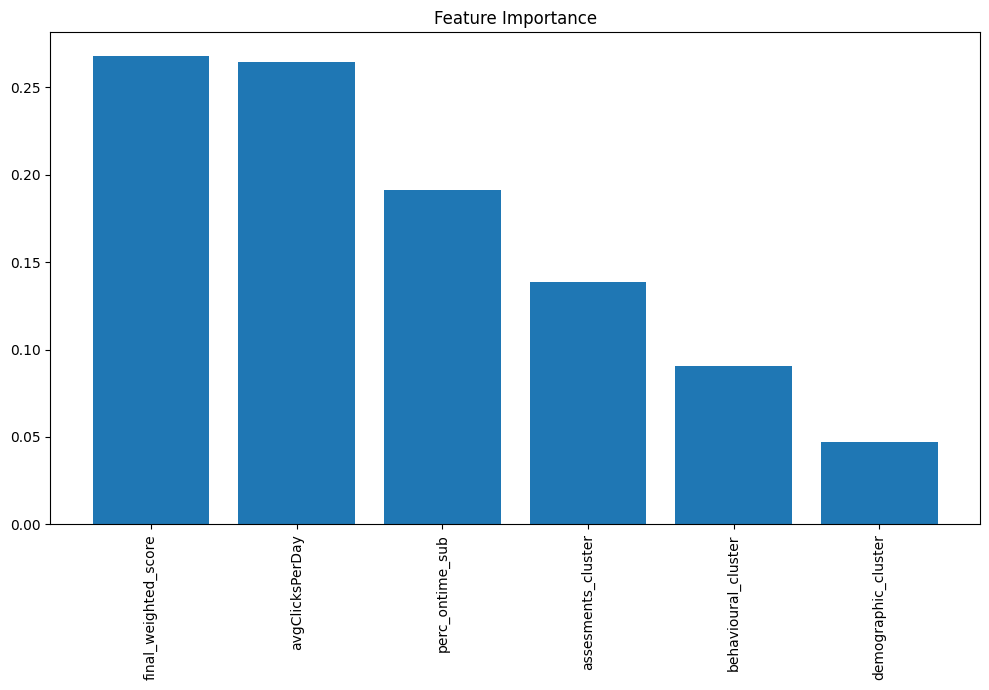

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title('Feature Importance')
plt.bar(range(X_train_demo.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train_demo.shape[1]), X_train_demo.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

#### Logistic Regression

In [75]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Logistic regression as an example model
log_reg = LogisticRegression()

rfe = RFE(estimator=log_reg, n_features_to_select=5)  # Select top 3 features
rfe.fit(X_train_demo, y_train_demo)

# Summarize selected features
selected_features_df = pd.DataFrame({
    'Feature': X_train_demo.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
})

print(selected_features_df[selected_features_df['Selected'] == True])

                Feature  Selected  Ranking
0       avgClicksPerDay      True        1
1  final_weighted_score      True        1
2       perc_ontime_sub      True        1
3   demographic_cluster      True        1
4   behavioural_cluster      True        1


#### Chi-squared Test

In [76]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# Applying the Chi-Squared Test
# Create and fit selector
chi2_selector = SelectKBest(chi2, k='all')  # 'all' can be replaced with any numeric value if you want to limit the number of features
X_kbest_features = chi2_selector.fit_transform(X_train_demo, y_train_demo)

# See the scores for each feature
chi_scores = chi2_selector.scores_

# Create a DataFrame with the scores and corresponding feature names
features_scores = pd.DataFrame({'Feature': X_train_demo.columns, 'Score': chi_scores})
features_scores = features_scores.sort_values(by='Score', ascending=False)

# Display the features with their chi2 scores
print(features_scores)

                Feature        Score
5    assesments_cluster  1179.978181
0       avgClicksPerDay   496.487319
4   behavioural_cluster   340.800316
2       perc_ontime_sub   248.030797
1  final_weighted_score   222.981972
3   demographic_cluster    78.633221


In [77]:
X_train_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31638 entries, 0 to 31637
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avgClicksPerDay       31638 non-null  float64
 1   final_weighted_score  31638 non-null  float64
 2   perc_ontime_sub       31638 non-null  float64
 3   demographic_cluster   31638 non-null  uint16 
 4   behavioural_cluster   31638 non-null  int32  
 5   assesments_cluster    31638 non-null  int32  
dtypes: float64(3), int32(2), uint16(1)
memory usage: 1.0 MB


In [78]:
# X_train_demo['demographic_cluster'] = X_train_demo['demographic_cluster'].astype(int)
# X_test_demo['demographic_cluster'] = X_test_demo['demographic_cluster'].astype(int)

# X_train_demo['behavioural_cluster'] = X_train_demo['behavioural_cluster'].astype(int)
# X_test_demo['behavioural_cluster'] = X_test_demo['behavioural_cluster'].astype(int)

# X_train_demo['assesments_cluster'] = X_train_demo['assesments_cluster'].astype(int)
# X_test_demo['assesments_cluster'] = X_test_demo['assesments_cluster'].astype(int)

#### XGBoost

In [79]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import load_breast_cancer

# Initialize and train the XGBoost classifier
model = XGBClassifier()
model.fit(X_train_demo, y_train_demo)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

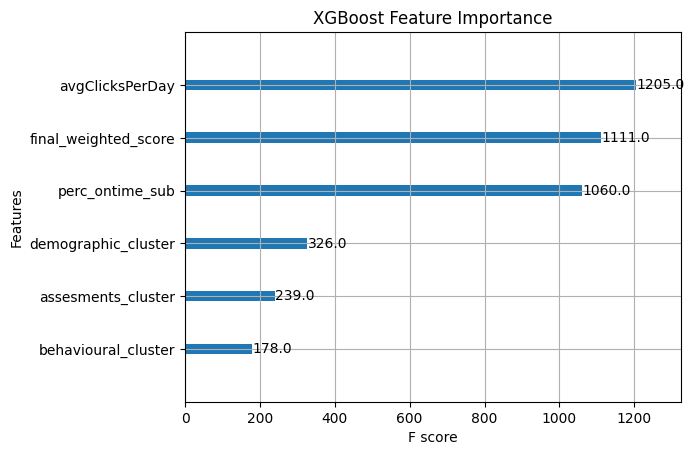

In [80]:
# Plot feature importances
xgb.plot_importance(model)
plt.title("XGBoost Feature Importance")
plt.show()

#### Select Features

In [81]:
X_train_xgb = X_train_demo[['avgClicksPerDay', 'final_weighted_score', 'perc_ontime_sub',
                         'demographic_cluster', 'behavioural_cluster', 'assesments_cluster']]

In [82]:
X_test_xgb = X_test_demo[['avgClicksPerDay', 'final_weighted_score', 'perc_ontime_sub',
                         'demographic_cluster', 'behavioural_cluster', 'assesments_cluster']]

In [83]:
y_train_xgb = y_train_demo

In [84]:
y_test_xgb = y_test_demo

In [85]:
print(X_train_xgb.shape)
print(y_train_xgb.shape)
print(X_test_xgb.shape)
print(y_test_xgb.shape)

(31638, 6)
(31638,)
(6449, 6)
(6449,)


## 5.3) Demographic data modeling

In [86]:
global xgb_model
X_train_xgb = X_train_demo[['avgClicksPerDay', 'final_weighted_score', 'perc_ontime_sub',
                         'demographic_cluster', 'behavioural_cluster', 'assesments_cluster']]
X_test_xgb = X_test_demo[['avgClicksPerDay', 'final_weighted_score', 'perc_ontime_sub',
                         'demographic_cluster', 'behavioural_cluster', 'assesments_cluster']]
y_train_xgb = y_train_demo
y_test_xgb = y_test_demo

xgb_model = xgb.XGBClassifier(
    max_depth=3,          # maximum depth of each tree
    n_estimators=100,     # number of trees
    learning_rate=0.05,    # learning rate
    use_label_encoder=False,  # to avoid a deprecation warning from XGBoost regarding label encoding
    eval_metric='mlogloss'  # evaluation metric for multiclass classification
)
xgb_model.fit(X_train_xgb, y_train_xgb)

# Predictions
xgb_prediction = xgb_model.predict(X_test_xgb)

# Evaluation
accuracy = accuracy_score(y_test_xgb, xgb_prediction)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test_xgb, xgb_prediction))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:25:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 73.11%
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      5301
           1       0.33      0.48      0.39      1148

    accuracy                           0.73      6449
   macro avg       0.60      0.63      0.61      6449
weighted avg       0.78      0.73      0.75      6449



In [87]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_xgb, y_train_xgb)

# Predict on the test set
rf_predictions = rf_model.predict(X_test_xgb)

# Evaluate the model
print(f"Test Accuracy: {accuracy_score(y_test_xgb, rf_predictions) * 100:.2f}%")
print(classification_report(y_test_xgb, rf_predictions))

Test Accuracy: 78.94%
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5301
           1       0.41      0.40      0.40      1148

    accuracy                           0.79      6449
   macro avg       0.64      0.64      0.64      6449
weighted avg       0.79      0.79      0.79      6449



## 5.4) Meta-model combining two previous models

In [88]:
from scipy.stats import mode

# Simple majority vote
final_predictions = mode(np.column_stack((tsf_prediction, xgb_prediction)), axis=1)[0]

In [89]:
X_test_ts

,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,...,260,261,262,263,264,265,266,267,268,269
14826,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10506,0,0,0,0,0,0,0,0,0,52,...,0,0,0,0,0,0,0,0,0,0
21229,0,0,0,0,0,0,0,24,0,0,...,0,0,0,0,0,0,0,0,0,0
1915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17342,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25691,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8300,0,0,0,0,0,0,0,0,0,0,...,2,1,0,3,0,8,1,0,1,1
11625,0,0,0,0,0,0,0,3,2,2,...,0,5,0,0,0,0,0,0,0,0


In [90]:
# Assuming the predictions are probabilities or continuous scores
ts_probs = tsf.predict_proba(X_test_tsf)[:, 1]  # Get probability of class 1
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]

In [91]:
meta_features_logi = np.column_stack((ts_probs, xgb_probs))

In [92]:
from sklearn.linear_model import LogisticRegression
meta_model_logi = LogisticRegression()
meta_model_logi.fit(meta_features_logi, y_test_ts)

LogisticRegression()

In [93]:
meta_predictions_logi = meta_model_logi.predict(meta_features_logi)

In [94]:
accuracy = accuracy_score(y_test_ts, meta_predictions_logi)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test_ts, meta_predictions_logi))

Accuracy: 86.62%
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      5301
           1       0.62      0.66      0.64      1148

    accuracy                           0.87      6449
   macro avg       0.77      0.79      0.78      6449
weighted avg       0.87      0.87      0.87      6449



In [95]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test_ts, meta_predictions_logi)
cnf_matrix

array([[4824,  477],
       [ 386,  762]])

Text(0.5, 427.9555555555555, 'Predicted label')

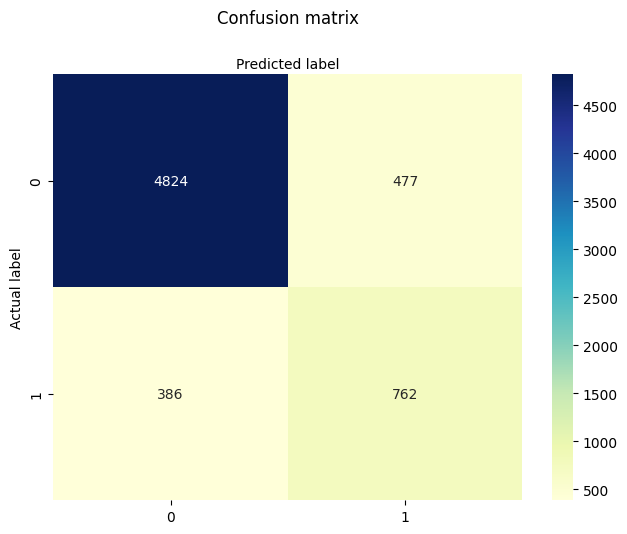

In [96]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [149]:
meta_model_logi.predict_proba(meta_features_logi)

array([[0.91215443, 0.08784557],
       [0.98388101, 0.01611899],
       [0.6126706 , 0.3873294 ],
       ...,
       [0.98253613, 0.01746387],
       [0.98475559, 0.01524441],
       [0.98782426, 0.01217574]])

In [150]:
meta_model_logi.predict_proba(meta_features_logi)[::,1]

array([0.08784557, 0.01611899, 0.3873294 , ..., 0.01746387, 0.01524441,
       0.01217574])

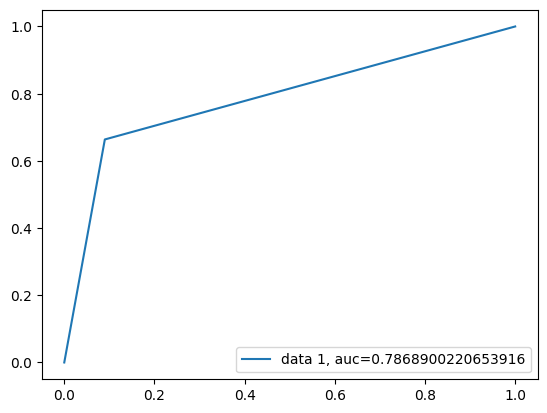

In [151]:
# y_pred_proba = meta_model_logi.predict_proba(meta_features_logi)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_ts, meta_predictions_logi)
auc = metrics.roc_auc_score(y_test_ts, meta_predictions_logi)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

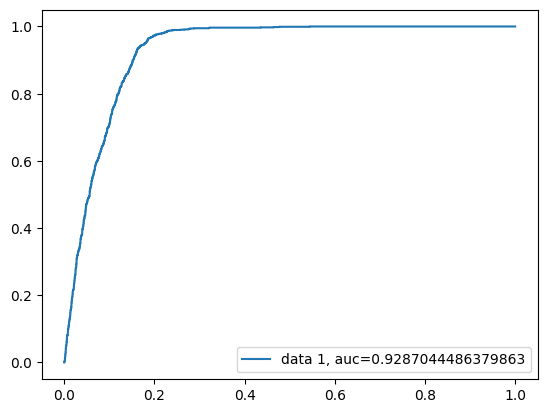

In [97]:
y_pred_proba = meta_model_logi.predict_proba(meta_features_logi)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_ts, y_pred_proba)
auc = metrics.roc_auc_score(y_test_ts, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# 6. Early Dropout

In [98]:
X_train_ts = X_train_balanced.drop(['avgClicksPerDay', 'final_weighted_score', 'perc_ontime_sub',
                         'demographic_cluster', 'behavioural_cluster', 'assesments_cluster'], axis=1)
X_test_ts = X_test.drop(['avgClicksPerDay', 'final_weighted_score', 'perc_ontime_sub',
                         'demographic_cluster', 'behavioural_cluster', 'assesments_cluster'], axis=1)
y_train_ts = y_train_balanced
y_test_ts = y_test

In [99]:
print(X_train_ts.shape)
print(y_train_ts.shape)
print(X_test_ts.shape)
print(y_test_ts.shape)

(31638, 295)
(31638,)
(6449, 295)
(6449,)


In [100]:
X_train_ts.columns = X_train_ts.columns.astype(float).astype(int)
X_test_ts.columns = X_test_ts.columns.astype(float).astype(int)

In [101]:
X_train_ts.head()

,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,...,260,261,262,263,264,265,266,267,268,269
0,0,0,0,0,0,0,0,2,4,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,3,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,61,1,1,0,1,7,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
X_test_ts

,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,...,260,261,262,263,264,265,266,267,268,269
14826,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10506,0,0,0,0,0,0,0,0,0,52,...,0,0,0,0,0,0,0,0,0,0
21229,0,0,0,0,0,0,0,24,0,0,...,0,0,0,0,0,0,0,0,0,0
1915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17342,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25691,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8300,0,0,0,0,0,0,0,0,0,0,...,2,1,0,3,0,8,1,0,1,1
11625,0,0,0,0,0,0,0,3,2,2,...,0,5,0,0,0,0,0,0,0,0


In [103]:
y_test_ts

array([1, 0, 0, ..., 0, 0, 0])

In [104]:
# Convert y_train_ts and y_test_ts to DataFrame and rename the column to 'isDropout'
y_train_col = pd.DataFrame(y_train_ts, columns=['isDropout'])
y_test_col = pd.DataFrame(y_test_ts, columns=['isDropout'])

X_train_reset = X_train_ts.reset_index(drop=True)
y_train_reset = y_train_col.reset_index(drop=True)

X_test_reset = X_test_ts.reset_index(drop=True)
y_test_reset = y_test_col.reset_index(drop=True)

# Concatenate the features and target for training set
train_combined = pd.concat([X_train_reset, y_train_reset], axis=1)

# Concatenate the features and target for testing set
test_combined = pd.concat([X_test_reset, y_test_reset], axis=1)

# Verify the shapes and columns
print(train_combined.shape)
print(train_combined.columns)
print(test_combined.shape)
print(test_combined.columns)

(31638, 296)
Index([        -25,         -24,         -23,         -22,         -21,
               -20,         -19,         -18,         -17,         -16,
       ...
               261,         262,         263,         264,         265,
               266,         267,         268,         269, 'isDropout'],
      dtype='object', length=296)
(6449, 296)
Index([        -25,         -24,         -23,         -22,         -21,
               -20,         -19,         -18,         -17,         -16,
       ...
               261,         262,         263,         264,         265,
               266,         267,         268,         269, 'isDropout'],
      dtype='object', length=296)


In [105]:
train_combined.head()

,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,...,261,262,263,264,265,266,267,268,269,isDropout
0,0,0,0,0,0,0,0,2,4,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4,0,3,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,61,1,1,0,1,7,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
test_combined.head()

,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,...,261,262,263,264,265,266,267,268,269,isDropout
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,52,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,24,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
# Manually creating each subset
train_1 = train_combined[['isDropout'] + [x for x in range(-25, 0) if x in train_combined.columns]]
train_2 = train_combined[['isDropout'] + [x for x in range(-25, 30) if x in train_combined.columns]]
train_3 = train_combined[['isDropout'] + [x for x in range(-25, 60) if x in train_combined.columns]]
train_4 = train_combined[['isDropout'] + [x for x in range(-25, 90) if x in train_combined.columns]]
train_5 = train_combined[['isDropout'] + [x for x in range(-25, 120) if x in train_combined.columns]]
train_6 = train_combined[['isDropout'] + [x for x in range(-25, 150) if x in train_combined.columns]]
train_7 = train_combined[['isDropout'] + [x for x in range(-25, 180) if x in train_combined.columns]]
train_8 = train_combined[['isDropout'] + [x for x in range(-25, 210) if x in train_combined.columns]]
train_9 = train_combined[['isDropout'] + [x for x in range(-25, 240) if x in train_combined.columns]]
train_10 = train_combined[['isDropout'] + [x for x in range(-25, 270) if x in train_combined.columns]]

In [108]:
train_1.head()

,isDropout,-25,-24,-23,-22,-21,-20,-19,-18,-17,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
0,0,0,0,0,0,0,0,0,2,4,...,0,0,1,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,6,40,0,0,0,0,1,0,1
2,0,4,0,3,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,4,56
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,0,0,0
4,0,0,61,1,1,0,1,7,0,2,...,0,6,1,0,22,0,11,0,1,46


In [109]:
X_train_ts_1 = train_1.drop(['isDropout'], axis=1)
y_train_ts_1 = train_1['isDropout']

X_train_ts_2 = train_2.drop(['isDropout'], axis=1)
y_train_ts_2 = train_2['isDropout']

X_train_ts_3 = train_3.drop(['isDropout'], axis=1)
y_train_ts_3 = train_3['isDropout']

X_train_ts_4 = train_4.drop(['isDropout'], axis=1)
y_train_ts_4 = train_4['isDropout']

X_train_ts_5 = train_5.drop(['isDropout'], axis=1)
y_train_ts_5 = train_5['isDropout']

X_train_ts_6 = train_6.drop(['isDropout'], axis=1)
y_train_ts_6 = train_6['isDropout']

X_train_ts_7 = train_7.drop(['isDropout'], axis=1)
y_train_ts_7 = train_7['isDropout']

X_train_ts_8 = train_8.drop(['isDropout'], axis=1)
y_train_ts_8 = train_8['isDropout']

X_train_ts_9 = train_9.drop(['isDropout'], axis=1)
y_train_ts_9 = train_9['isDropout']

X_train_ts_10 = train_10.drop(['isDropout'], axis=1)
y_train_ts_10 = train_10['isDropout']

In [110]:
# Manually creating each subset
test_1 = test_combined[['isDropout'] + [x for x in range(-25, 0) if x in test_combined.columns]]
test_2 = test_combined[['isDropout'] + [x for x in range(-25, 30) if x in test_combined.columns]]
test_3 = test_combined[['isDropout'] + [x for x in range(-25, 60) if x in test_combined.columns]]
test_4 = test_combined[['isDropout'] + [x for x in range(-25, 90) if x in test_combined.columns]]
test_5 = test_combined[['isDropout'] + [x for x in range(-25, 120) if x in test_combined.columns]]
test_6 = test_combined[['isDropout'] + [x for x in range(-25, 150) if x in test_combined.columns]]
test_7 = test_combined[['isDropout'] + [x for x in range(-25, 180) if x in test_combined.columns]]
test_8 = test_combined[['isDropout'] + [x for x in range(-25, 210) if x in test_combined.columns]]
test_9 = test_combined[['isDropout'] + [x for x in range(-25, 240) if x in test_combined.columns]]
test_10 = test_combined[['isDropout'] + [x for x in range(-25, 270) if x in test_combined.columns]]

In [111]:
X_test_ts_1 = test_1.drop(['isDropout'], axis=1)
y_test_ts_1 = test_1['isDropout']

X_test_ts_2 = test_2.drop(['isDropout'], axis=1)
y_test_ts_2 = test_2['isDropout']

X_test_ts_3 = test_3.drop(['isDropout'], axis=1)
y_test_ts_3 = test_3['isDropout']

X_test_ts_4 = test_4.drop(['isDropout'], axis=1)
y_test_ts_4 = test_4['isDropout']

X_test_ts_5 = test_5.drop(['isDropout'], axis=1)
y_test_ts_5 = test_5['isDropout']

X_test_ts_6 = test_6.drop(['isDropout'], axis=1)
y_test_ts_6 = test_6['isDropout']

X_test_ts_7 = test_7.drop(['isDropout'], axis=1)
y_test_ts_7 = test_7['isDropout']

X_test_ts_8 = test_8.drop(['isDropout'], axis=1)
y_test_ts_8 = test_8['isDropout']

X_test_ts_9 = test_9.drop(['isDropout'], axis=1)
y_test_ts_9 = test_9['isDropout']

X_test_ts_10 = test_10.drop(['isDropout'], axis=1)
y_test_ts_10 = test_10['isDropout']

In [112]:
test_1.head()

,isDropout,-25,-24,-23,-22,-21,-20,-19,-18,-17,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,2,3,0,0,0,8,4,0,0
2,0,0,0,0,0,0,0,0,24,0,...,0,0,0,3,0,0,0,18,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,17,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,13,0,0,0,0


In [113]:
print(X_train_ts_1.shape)
print(y_train_ts_1.shape)
print(X_test_ts_1.shape)
print(y_test_ts_1.shape)
print(X_train_xgb.shape)
print(y_train_xgb.shape)
print(X_test_xgb.shape)
print(y_test_xgb.shape)

(31638, 25)
(31638,)
(6449, 25)
(6449,)
(31638, 6)
(31638,)
(6449, 6)
(6449,)


In [114]:
print(X_train_ts_2.shape)
print(y_train_ts_2.shape)
print(X_test_ts_2.shape)
print(y_test_ts_2.shape)

(31638, 55)
(31638,)
(6449, 55)
(6449,)


1st Iteration

In [115]:
X_train_tsf_1 = X_train_ts_1.values.reshape((X_train_ts_1.shape[0], 1, X_train_ts_1.shape[1]))
X_test_tsf_1 = X_test_ts_1.values.reshape((X_test_ts_1.shape[0], 1, X_test_ts_1.shape[1]))

y_train_tsf_1 = pd.Series(y_train_ts_1)
y_test_tsf_1 = pd.Series(y_test_ts_1)

tsf_1 = TimeSeriesForestClassifier(n_estimators=100, random_state=42)
tsf_1.fit(X_train_tsf_1, y_train_tsf_1)

tsf_prediction_1 = tsf_1.predict(X_test_tsf_1)
tsf_accuracy_1 = accuracy_score(y_test_tsf_1, tsf_prediction_1)

print(f"Test Accuracy: {accuracy_score(y_test_tsf_1, tsf_prediction_1) * 100:.2f}%")
print(classification_report(y_test_tsf_1, tsf_prediction_1))

Test Accuracy: 66.06%
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      5301
           1       0.21      0.33      0.26      1148

    accuracy                           0.66      6449
   macro avg       0.52      0.53      0.52      6449
weighted avg       0.72      0.66      0.69      6449



In [116]:
ts_probs_1 = tsf_1.predict_proba(X_test_tsf_1)[:, 1]  # Get probability of class 1
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]
meta_features_logi_1 = np.column_stack((ts_probs_1, xgb_probs))
meta_model_logi_1 = LogisticRegression()
meta_model_logi_1.fit(meta_features_logi_1, y_test_ts_1)
meta_predictions_logi_1 = meta_model_logi_1.predict(meta_features_logi_1)

final_accuracy_1 = accuracy_score(y_test_ts_1, meta_predictions_logi_1)
print(f"Accuracy: {final_accuracy_1 * 100:.2f}%")
print(classification_report(y_test_ts_1, meta_predictions_logi_1))

Accuracy: 82.62%
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      5301
           1       0.71      0.04      0.07      1148

    accuracy                           0.83      6449
   macro avg       0.77      0.52      0.49      6449
weighted avg       0.81      0.83      0.76      6449



In [117]:
y_pred_proba_1 = meta_model_logi_1.predict_proba(meta_features_logi_1)[::,1]
auc_1 = metrics.roc_auc_score(y_test_ts_1, y_pred_proba_1)
auc_1

0.6963026994446515

2nd Iteration

In [118]:
X_train_tsf_2 = X_train_ts_2.values.reshape((X_train_ts_2.shape[0], 1, X_train_ts_2.shape[1]))
X_test_tsf_2 = X_test_ts_2.values.reshape((X_test_ts_2.shape[0], 1, X_test_ts_2.shape[1]))

y_train_tsf_2 = pd.Series(y_train_ts_2)
y_test_tsf_2 = pd.Series(y_test_ts_2)

tsf_2 = TimeSeriesForestClassifier(n_estimators=100, random_state=42)
tsf_2.fit(X_train_tsf_2, y_train_tsf_2)

tsf_prediction_2 = tsf_2.predict(X_test_tsf_2)
tsf_accuracy_2 = accuracy_score(y_test_tsf_2, tsf_prediction_2)

print(f"Test Accuracy: {accuracy_score(y_test_tsf_2, tsf_prediction_2) * 100:.2f}%")
print(classification_report(y_test_tsf_2, tsf_prediction_2))

Test Accuracy: 71.36%
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      5301
           1       0.22      0.24      0.23      1148

    accuracy                           0.71      6449
   macro avg       0.53      0.53      0.53      6449
weighted avg       0.72      0.71      0.72      6449



In [119]:
ts_probs_2 = tsf_2.predict_proba(X_test_tsf_2)[:, 1]  # Get probability of class 1
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]
meta_features_logi_2 = np.column_stack((ts_probs_2, xgb_probs))
meta_model_logi_2 = LogisticRegression()
meta_model_logi_2.fit(meta_features_logi_2, y_test_ts_2)
meta_predictions_logi_2 = meta_model_logi_2.predict(meta_features_logi_2)

final_accuracy_2 = accuracy_score(y_test_ts_2, meta_predictions_logi_2)
print(f"Accuracy: {final_accuracy_2 * 100:.2f}%")
print(classification_report(y_test_ts_2, meta_predictions_logi_2))

Accuracy: 82.56%
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      5301
           1       0.69      0.04      0.07      1148

    accuracy                           0.83      6449
   macro avg       0.76      0.52      0.49      6449
weighted avg       0.80      0.83      0.76      6449



In [120]:
y_pred_proba_2 = meta_model_logi_2.predict_proba(meta_features_logi_2)[::,1]
auc_2 = metrics.roc_auc_score(y_test_ts_2, y_pred_proba_2)
auc_2

0.6963383576959709

3rd Iteratioin

In [121]:
X_train_tsf_3 = X_train_ts_3.values.reshape((X_train_ts_3.shape[0], 1, X_train_ts_3.shape[1]))
X_test_tsf_3 = X_test_ts_3.values.reshape((X_test_ts_3.shape[0], 1, X_test_ts_3.shape[1]))

y_train_tsf_3 = pd.Series(y_train_ts_3)
y_test_tsf_3 = pd.Series(y_test_ts_3)

tsf_3 = TimeSeriesForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
tsf_3.fit(X_train_tsf_3, y_train_tsf_3)

tsf_prediction_3 = tsf_3.predict(X_test_tsf_3)
tsf_accuracy_3 = accuracy_score(y_test_tsf_3, tsf_prediction_3)

print(f"Test Accuracy: {accuracy_score(y_test_tsf_3, tsf_prediction_3) * 100:.2f}%")
print(classification_report(y_test_tsf_3, tsf_prediction_3))

Test Accuracy: 75.38%
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5301
           1       0.33      0.37      0.35      1148

    accuracy                           0.75      6449
   macro avg       0.59      0.60      0.60      6449
weighted avg       0.77      0.75      0.76      6449



In [122]:
ts_probs_3 = tsf_3.predict_proba(X_test_tsf_3)[:, 1]  # Get probability of class 1
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]
meta_features_logi_3 = np.column_stack((ts_probs_3, xgb_probs))
meta_model_logi_3 = LogisticRegression()
meta_model_logi_3.fit(meta_features_logi_3, y_test_ts_3)
meta_predictions_logi_3 = meta_model_logi_3.predict(meta_features_logi_3)

final_accuracy_3 = accuracy_score(y_test_ts_3, meta_predictions_logi_3)
print(f"Accuracy: {final_accuracy_3 * 100:.2f}%")
print(classification_report(y_test_ts_3, meta_predictions_logi_3))

Accuracy: 82.99%
              precision    recall  f1-score   support

           0       0.83      0.99      0.91      5301
           1       0.66      0.09      0.16      1148

    accuracy                           0.83      6449
   macro avg       0.75      0.54      0.53      6449
weighted avg       0.80      0.83      0.77      6449



In [123]:
y_pred_proba_3 = meta_model_logi_3.predict_proba(meta_features_logi_3)[::,1]
auc_3 = metrics.roc_auc_score(y_test_ts_3, y_pred_proba_3)
auc_3

0.7162850412156802

4th Iteratioin

In [124]:
X_train_tsf_4 = X_train_ts_4.values.reshape((X_train_ts_4.shape[0], 1, X_train_ts_4.shape[1]))
X_test_tsf_4 = X_test_ts_4.values.reshape((X_test_ts_4.shape[0], 1, X_test_ts_4.shape[1]))

y_train_tsf_4 = pd.Series(y_train_ts_4)
y_test_tsf_4 = pd.Series(y_test_ts_4)

tsf_4 = TimeSeriesForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
tsf_4.fit(X_train_tsf_4, y_train_tsf_4)

tsf_prediction_4 = tsf_4.predict(X_test_tsf_4)
tsf_accuracy_4 = accuracy_score(y_test_tsf_4, tsf_prediction_4)

print(f"Test Accuracy: {accuracy_score(y_test_tsf_4, tsf_prediction_4) * 100:.2f}%")
print(classification_report(y_test_tsf_4, tsf_prediction_4))

Test Accuracy: 78.57%
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5301
           1       0.41      0.45      0.43      1148

    accuracy                           0.79      6449
   macro avg       0.64      0.65      0.65      6449
weighted avg       0.79      0.79      0.79      6449



In [125]:
ts_probs_4 = tsf_4.predict_proba(X_test_tsf_4)[:, 1]  # Get probability of class 1
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]
meta_features_logi_4 = np.column_stack((ts_probs_4, xgb_probs))
meta_model_logi_4 = LogisticRegression()
meta_model_logi_4.fit(meta_features_logi_4, y_test_ts_4)
meta_predictions_logi_4 = meta_model_logi_4.predict(meta_features_logi_4)

final_accuracy_4 = accuracy_score(y_test_ts_4, meta_predictions_logi_4)
print(f"Accuracy: {final_accuracy_4 * 100:.2f}%")
print(classification_report(y_test_ts_4, meta_predictions_logi_4))

Accuracy: 83.98%
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      5301
           1       0.67      0.20      0.30      1148

    accuracy                           0.84      6449
   macro avg       0.76      0.59      0.61      6449
weighted avg       0.82      0.84      0.80      6449



In [126]:
y_pred_proba_4 = meta_model_logi_4.predict_proba(meta_features_logi_4)[::,1]
auc_4 = metrics.roc_auc_score(y_test_ts_4, y_pred_proba_4)
auc_4

0.7508838973909991

5th Iteratioin

In [127]:
X_train_tsf_5 = X_train_ts_5.values.reshape((X_train_ts_5.shape[0], 1, X_train_ts_5.shape[1]))
X_test_tsf_5 = X_test_ts_5.values.reshape((X_test_ts_5.shape[0], 1, X_test_ts_5.shape[1]))

y_train_tsf_5 = pd.Series(y_train_ts_5)
y_test_tsf_5 = pd.Series(y_test_ts_5)

tsf_5 = TimeSeriesForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
tsf_5.fit(X_train_tsf_5, y_train_tsf_5)

tsf_prediction_5 = tsf_5.predict(X_test_tsf_5)
tsf_accuracy_5 = accuracy_score(y_test_tsf_5, tsf_prediction_5)

print(f"Test Accuracy: {accuracy_score(y_test_tsf_5, tsf_prediction_5) * 100:.2f}%")
print(classification_report(y_test_tsf_5, tsf_prediction_5))

Test Accuracy: 81.52%
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      5301
           1       0.48      0.61      0.54      1148

    accuracy                           0.82      6449
   macro avg       0.70      0.73      0.71      6449
weighted avg       0.83      0.82      0.82      6449



In [128]:
ts_probs_5 = tsf_5.predict_proba(X_test_tsf_5)[:, 1]  # Get probability of class 1
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]
meta_features_logi_5 = np.column_stack((ts_probs_5, xgb_probs))
meta_model_logi_5 = LogisticRegression()
meta_model_logi_5.fit(meta_features_logi_5, y_test_ts_5)
meta_predictions_logi_5 = meta_model_logi_5.predict(meta_features_logi_5)

final_accuracy_5 = accuracy_score(y_test_ts_5, meta_predictions_logi_5)
final_classification_report_5 = classification_report(y_test_ts_5, meta_predictions_logi_5)

print(f"Accuracy: {final_accuracy_5 * 100:.2f}%")
print(final_classification_report_5)

Accuracy: 84.23%
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5301
           1       0.60      0.34      0.44      1148

    accuracy                           0.84      6449
   macro avg       0.73      0.65      0.67      6449
weighted avg       0.82      0.84      0.82      6449



In [129]:
y_pred_proba_5 = meta_model_logi_5.predict_proba(meta_features_logi_5)[::,1]
auc_5 = metrics.roc_auc_score(y_test_ts_5, y_pred_proba_5)
auc_5

0.8219709219284771

6th Iteration

In [130]:
X_train_tsf_6 = X_train_ts_6.values.reshape((X_train_ts_6.shape[0], 1, X_train_ts_6.shape[1]))
X_test_tsf_6 = X_test_ts_6.values.reshape((X_test_ts_6.shape[0], 1, X_test_ts_6.shape[1]))

y_train_tsf_6 = pd.Series(y_train_ts_6)
y_test_tsf_6 = pd.Series(y_test_ts_6)

tsf_6 = TimeSeriesForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
tsf_6.fit(X_train_tsf_6, y_train_tsf_6)

tsf_prediction_6 = tsf_6.predict(X_test_tsf_6)
tsf_accuracy_6 = accuracy_score(y_test_tsf_6, tsf_prediction_6)
tsf_classification_report_6 = classification_report(y_test_tsf_6, tsf_prediction_6)

print(f"Test Accuracy: {tsf_accuracy_6 * 100:.2f}%")
print(tsf_classification_report_6)

Test Accuracy: 83.75%
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      5301
           1       0.53      0.73      0.61      1148

    accuracy                           0.84      6449
   macro avg       0.73      0.79      0.76      6449
weighted avg       0.86      0.84      0.85      6449



In [131]:
ts_probs_6 = tsf_6.predict_proba(X_test_tsf_6)[:, 1]  # Get probability of class 1
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]
meta_features_logi_6 = np.column_stack((ts_probs_6, xgb_probs))
meta_model_logi_6 = LogisticRegression()
meta_model_logi_6.fit(meta_features_logi_6, y_test_ts_6)
meta_predictions_logi_6 = meta_model_logi_6.predict(meta_features_logi_6)

final_accuracy_6 = accuracy_score(y_test_ts_6, meta_predictions_logi_6)
final_classification_report_6 = classification_report(y_test_ts_6, meta_predictions_logi_6)

print(f"Accuracy: {final_accuracy_6 * 100:.2f}%")
print(final_classification_report_6)

Accuracy: 85.44%
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5301
           1       0.61      0.49      0.54      1148

    accuracy                           0.85      6449
   macro avg       0.75      0.71      0.73      6449
weighted avg       0.84      0.85      0.85      6449



In [132]:
y_pred_proba_6 = meta_model_logi_6.predict_proba(meta_features_logi_6)[::,1]
auc_6 = metrics.roc_auc_score(y_test_ts_6, y_pred_proba_6)
auc_6

0.866542421487761

7th Iteration

In [133]:
X_train_tsf_7 = X_train_ts_7.values.reshape((X_train_ts_7.shape[0], 1, X_train_ts_7.shape[1]))
X_test_tsf_7 = X_test_ts_7.values.reshape((X_test_ts_7.shape[0], 1, X_test_ts_7.shape[1]))

y_train_tsf_7 = pd.Series(y_train_ts_7)
y_test_tsf_7 = pd.Series(y_test_ts_7)

tsf_7 = TimeSeriesForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
tsf_7.fit(X_train_tsf_7, y_train_tsf_7)

tsf_prediction_7 = tsf_7.predict(X_test_tsf_7)
tsf_accuracy_7 = accuracy_score(y_test_tsf_7, tsf_prediction_7)
tsf_classification_report_7 = classification_report(y_test_tsf_7, tsf_prediction_7)

print(f"Test Accuracy: {tsf_accuracy_7 * 100:.2f}%")
print(tsf_classification_report_7)

Test Accuracy: 84.80%
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      5301
           1       0.55      0.81      0.65      1148

    accuracy                           0.85      6449
   macro avg       0.75      0.83      0.78      6449
weighted avg       0.88      0.85      0.86      6449



In [134]:
ts_probs_7 = tsf_7.predict_proba(X_test_tsf_7)[:, 1]  # Get probability of class 1
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]
meta_features_logi_7 = np.column_stack((ts_probs_7, xgb_probs))
meta_model_logi_7 = LogisticRegression()
meta_model_logi_7.fit(meta_features_logi_7, y_test_ts_7)
meta_predictions_logi_7 = meta_model_logi_7.predict(meta_features_logi_7)

final_accuracy_7 = accuracy_score(y_test_ts_7, meta_predictions_logi_7)
final_classification_report_7 = classification_report(y_test_ts_7, meta_predictions_logi_7)

print(f"Accuracy: {final_accuracy_7 * 100:.2f}%")
print(final_classification_report_7)

Accuracy: 86.14%
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      5301
           1       0.62      0.58      0.60      1148

    accuracy                           0.86      6449
   macro avg       0.76      0.75      0.76      6449
weighted avg       0.86      0.86      0.86      6449



In [135]:
y_pred_proba_7 = meta_model_logi_7.predict_proba(meta_features_logi_7)[::,1]
auc_7 = metrics.roc_auc_score(y_test_ts_7, y_pred_proba_7)
auc_7

0.897785211783721

8th Iteration

In [136]:
X_train_tsf_8 = X_train_ts_8.values.reshape((X_train_ts_8.shape[0], 1, X_train_ts_8.shape[1]))
X_test_tsf_8 = X_test_ts_8.values.reshape((X_test_ts_8.shape[0], 1, X_test_ts_8.shape[1]))

y_train_tsf_8 = pd.Series(y_train_ts_8)
y_test_tsf_8 = pd.Series(y_test_ts_8)

tsf_8 = TimeSeriesForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
tsf_8.fit(X_train_tsf_8, y_train_tsf_8)

tsf_prediction_8 = tsf_8.predict(X_test_tsf_8)
tsf_accuracy_8 = accuracy_score(y_test_tsf_8, tsf_prediction_8)
tsf_classification_report_8 = classification_report(y_test_tsf_8, tsf_prediction_8)

print(f"Test Accuracy: {tsf_accuracy_8 * 100:.2f}%")
print(tsf_classification_report_8)

Test Accuracy: 84.93%
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      5301
           1       0.55      0.85      0.67      1148

    accuracy                           0.85      6449
   macro avg       0.76      0.85      0.79      6449
weighted avg       0.89      0.85      0.86      6449



In [137]:
ts_probs_8 = tsf_8.predict_proba(X_test_tsf_8)[:, 1]  # Get probability of class 1
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]
meta_features_logi_8 = np.column_stack((ts_probs_8, xgb_probs))
meta_model_logi_8 = LogisticRegression()
meta_model_logi_8.fit(meta_features_logi_8, y_test_ts_8)
meta_predictions_logi_8 = meta_model_logi_8.predict(meta_features_logi_8)

final_accuracy_8 = accuracy_score(y_test_ts_8, meta_predictions_logi_8)
final_classification_report_8 = classification_report(y_test_ts_8, meta_predictions_logi_8)

print(f"Accuracy: {final_accuracy_8 * 100:.2f}%")
print(final_classification_report_8)

Accuracy: 85.94%
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      5301
           1       0.61      0.60      0.60      1148

    accuracy                           0.86      6449
   macro avg       0.76      0.76      0.76      6449
weighted avg       0.86      0.86      0.86      6449



In [138]:
y_pred_proba_8 = meta_model_logi_8.predict_proba(meta_features_logi_8)[::,1]
auc_8 = metrics.roc_auc_score(y_test_ts_8, y_pred_proba_8)
auc_8

0.9100420372988596

9th Iteration

In [139]:
X_train_tsf_9 = X_train_ts_9.values.reshape((X_train_ts_9.shape[0], 1, X_train_ts_9.shape[1]))
X_test_tsf_9 = X_test_ts_9.values.reshape((X_test_ts_9.shape[0], 1, X_test_ts_9.shape[1]))

y_train_tsf_9 = pd.Series(y_train_ts_9)
y_test_tsf_9 = pd.Series(y_test_ts_9)

tsf_9 = TimeSeriesForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
tsf_9.fit(X_train_tsf_9, y_train_tsf_9)

tsf_prediction_9 = tsf_9.predict(X_test_tsf_9)
tsf_accuracy_9 = accuracy_score(y_test_tsf_9, tsf_prediction_9)
tsf_classification_report_9 = classification_report(y_test_tsf_9, tsf_prediction_9)

print(f"Test Accuracy: {tsf_accuracy_9 * 100:.2f}%")
print(tsf_classification_report_9)

Test Accuracy: 85.52%
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      5301
           1       0.56      0.89      0.69      1148

    accuracy                           0.86      6449
   macro avg       0.77      0.87      0.80      6449
weighted avg       0.90      0.86      0.87      6449



In [140]:
ts_probs_9 = tsf_9.predict_proba(X_test_tsf_9)[:, 1]  # Get probability of class 1
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]
meta_features_logi_9 = np.column_stack((ts_probs_9, xgb_probs))
meta_model_logi_9 = LogisticRegression()
meta_model_logi_9.fit(meta_features_logi_9, y_test_ts_9)
meta_predictions_logi_9 = meta_model_logi_9.predict(meta_features_logi_9)

final_accuracy_9 = accuracy_score(y_test_ts_9, meta_predictions_logi_9)
final_classification_report_9 = classification_report(y_test_ts_9, meta_predictions_logi_9)

print(f"Accuracy: {final_accuracy_9 * 100:.2f}%")
print(final_classification_report_9)

Accuracy: 86.51%
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      5301
           1       0.61      0.65      0.63      1148

    accuracy                           0.87      6449
   macro avg       0.77      0.78      0.77      6449
weighted avg       0.87      0.87      0.87      6449



In [141]:
y_pred_proba_9 = meta_model_logi_9.predict_proba(meta_features_logi_9)[::,1]
auc_9 = metrics.roc_auc_score(y_test_ts_9, y_pred_proba_9)
auc_9

0.924561518535389

10th Iteration

In [142]:
X_train_tsf_10 = X_train_ts_10.values.reshape((X_train_ts_10.shape[0], 1, X_train_ts_10.shape[1]))
X_test_tsf_10 = X_test_ts_10.values.reshape((X_test_ts_10.shape[0], 1, X_test_ts_10.shape[1]))

y_train_tsf_10 = pd.Series(y_train_ts_10)
y_test_tsf_10 = pd.Series(y_test_ts_10)

tsf_10 = TimeSeriesForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
tsf_10.fit(X_train_tsf_10, y_train_tsf_10)

tsf_prediction_10 = tsf_10.predict(X_test_tsf_10)
tsf_accuracy_10 = accuracy_score(y_test_tsf_10, tsf_prediction_10)
tsf_classification_report_10 = classification_report(y_test_tsf_10, tsf_prediction_10)

print(f"Test Accuracy: {tsf_accuracy_10 * 100:.2f}%")
print(tsf_classification_report_10)

Test Accuracy: 85.66%
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5301
           1       0.56      0.91      0.69      1148

    accuracy                           0.86      6449
   macro avg       0.77      0.88      0.80      6449
weighted avg       0.90      0.86      0.87      6449



In [159]:
y_pred_proba_tsf_10 = tsf_10.predict_proba(X_test_tsf_10)[::,1]
tsf_auc_10 = metrics.roc_auc_score(y_test_tsf_10, y_pred_proba_tsf_10)
tsf_auc_10

0.9277428261185352

In [143]:
ts_probs_10 = tsf_10.predict_proba(X_test_tsf_10)[:, 1]  # Get probability of class 1
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]
meta_features_logi_10 = np.column_stack((ts_probs_10, xgb_probs))
meta_model_logi_10 = LogisticRegression()
meta_model_logi_10.fit(meta_features_logi_10, y_test_ts_10)
meta_predictions_logi_10 = meta_model_logi_10.predict(meta_features_logi_10)

final_accuracy_10 = accuracy_score(y_test_ts_10, meta_predictions_logi_10)
final_classification_report_10 = classification_report(y_test_ts_10, meta_predictions_logi_10)

print(f"Accuracy: {final_accuracy_10 * 100:.2f}%")
print(final_classification_report_10)

Accuracy: 86.62%
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      5301
           1       0.62      0.66      0.64      1148

    accuracy                           0.87      6449
   macro avg       0.77      0.79      0.78      6449
weighted avg       0.87      0.87      0.87      6449



In [144]:
y_pred_proba_10 = meta_model_logi_10.predict_proba(meta_features_logi_10)[::,1]
auc_10 = metrics.roc_auc_score(y_test_ts_10, y_pred_proba_10)
auc_10

0.9287044486379863

In [145]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [152]:
## Meta Model Metrics
cuts = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270]
results = []

for cut in cuts:

  if cut == 0:
    y_test_early = y_test_ts_1
    meta_predictions_early = meta_predictions_logi_1
    meta_predictions_early_score = y_pred_proba_1

  elif cut == 30:
    y_test_early = y_test_ts_2
    meta_predictions_early = meta_predictions_logi_2
    meta_predictions_early_score = y_pred_proba_2

  elif cut == 60:
    y_test_early = y_test_ts_3
    meta_predictions_early = meta_predictions_logi_3
    meta_predictions_early_score = y_pred_proba_3

  elif cut == 90:
    y_test_early = y_test_ts_4
    meta_predictions_early = meta_predictions_logi_4
    meta_predictions_early_score = y_pred_proba_4

  elif cut == 120:
    y_test_early = y_test_ts_5
    meta_predictions_early = meta_predictions_logi_5
    meta_predictions_early_score = y_pred_proba_5

  elif cut == 150:
    y_test_early = y_test_ts_6
    meta_predictions_early = meta_predictions_logi_6
    meta_predictions_early_score = y_pred_proba_6

  elif cut == 180:
    y_test_early = y_test_ts_7
    meta_predictions_early = meta_predictions_logi_7
    meta_predictions_early_score = y_pred_proba_7

  elif cut == 210:
    y_test_early = y_test_ts_8
    meta_predictions_early = meta_predictions_logi_8
    meta_predictions_early_score = y_pred_proba_8

  elif cut == 240:
    y_test_early = y_test_ts_9
    meta_predictions_early = meta_predictions_logi_9
    meta_predictions_early_score = y_pred_proba_9

  elif cut == 270:
    y_test_early = y_test_ts_10
    meta_predictions_early = meta_predictions_logi_10
    meta_predictions_early_score = y_pred_proba_10


  accuracy = accuracy_score(y_test_early, meta_predictions_early)
  precision = precision_score(y_test_early, meta_predictions_early)
  recall = recall_score(y_test_early, meta_predictions_early)
  f1 = f1_score(y_test_early, meta_predictions_early)
  roc_auc = metrics.roc_auc_score(y_test_early, meta_predictions_early_score)

  results.append(["xgb + tsf", cut, accuracy, precision, recall, f1, roc_auc])


In [153]:
all_metrics = pd.DataFrame(data = results, columns=["Model", 'cut', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc'])

In [154]:
all_metrics

,Model,cut,accuracy,precision,recall,f1_score,roc_auc
0,xgb + tsf,0,0.826175,0.714286,0.039199,0.074319,0.696303
1,xgb + tsf,30,0.825554,0.688525,0.036585,0.069479,0.696338
2,xgb + tsf,60,0.829896,0.658385,0.092334,0.161956,0.716285
3,xgb + tsf,90,0.839820,0.671642,0.195993,0.303439,0.750884
4,xgb + tsf,120,0.842301,0.599393,0.344077,0.437189,0.821971
5,xgb + tsf,150,0.854396,0.614709,0.487805,0.543953,0.866542
6,xgb + tsf,180,0.861374,0.618250,0.578397,0.597660,0.897785
7,xgb + tsf,210,0.859358,0.605057,0.604530,0.604793,0.910042
8,xgb + tsf,240,0.865095,0.614686,0.648955,0.631356,0.924562
9,xgb + tsf,270,0.866181,0.615012,0.663763,0.638458,0.928704


In [157]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 2.0 MB/s eta 0:00:00


In [158]:
all_metrics.to_excel("results.xlsx")

In [ ]:
# Plot the DataFrame
plt.figure(figsize=(10, 6))
plt.plot(all_metrics['cut'], all_metrics['accuracy'], label='Accuracy')
plt.plot(all_metrics['cut'], all_metrics['precision'], label='Precision')
plt.plot(all_metrics['cut'], all_metrics['recall'], label='Recall')
plt.plot(all_metrics['cut'], all_metrics['f1_score'], label='f1_score')
plt.plot(all_metrics['cut'], all_metrics['roc_auc'], label='ROC-AUC')
plt.title('Model Performance Over Time')
plt.xlabel('Days')
plt.ylabel('Performance')
plt.grid(True)
plt.legend()
plt.xticks(cuts)
plt.show()

In [160]:
## TSF Metrics
cuts = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270]
tsf_results = []

y_pred_proba_tsf_10 = tsf_10.predict_proba(X_test_tsf_10)[::,1]
tsf_auc_10 = metrics.roc_auc_score(y_test_tsf_10, y_pred_proba_tsf_10)
tsf_auc_10

for cut in cuts:

  if cut == 0:
    y_test_early = y_test_ts_1
    tsf_prediction = tsf_prediction_1

    y_pred_proba_tsf_1 = tsf_1.predict_proba(X_test_tsf_1)[::,1]
    tsf_prediction_score = y_pred_proba_tsf_1

  elif cut == 30:
    y_test_early = y_test_ts_2
    tsf_prediction = tsf_prediction_2

    y_pred_proba_tsf_2 = tsf_2.predict_proba(X_test_tsf_2)[::,1]
    tsf_prediction_score = y_pred_proba_tsf_2

  elif cut == 60:
    y_test_early = y_test_ts_3
    tsf_prediction = tsf_prediction_3

    y_pred_proba_tsf_3 = tsf_3.predict_proba(X_test_tsf_3)[::,1]
    tsf_prediction_score = y_pred_proba_tsf_3

  elif cut == 90:
    y_test_early = y_test_ts_4
    tsf_prediction = tsf_prediction_4

    y_pred_proba_tsf_4 = tsf_4.predict_proba(X_test_tsf_4)[::,1]
    tsf_prediction_score = y_pred_proba_tsf_4

  elif cut == 120:
    y_test_early = y_test_ts_5
    tsf_prediction = tsf_prediction_5

    y_pred_proba_tsf_5 = tsf_5.predict_proba(X_test_tsf_5)[::,1]
    tsf_prediction_score = y_pred_proba_tsf_5

  elif cut == 150:
    y_test_early = y_test_ts_6
    tsf_prediction = tsf_prediction_6

    y_pred_proba_tsf_6 = tsf_6.predict_proba(X_test_tsf_6)[::,1]
    tsf_prediction_score = y_pred_proba_tsf_6

  elif cut == 180:
    y_test_early = y_test_ts_7
    tsf_prediction = tsf_prediction_7

    y_pred_proba_tsf_7 = tsf_7.predict_proba(X_test_tsf_7)[::,1]
    tsf_prediction_score = y_pred_proba_tsf_7

  elif cut == 210:
    y_test_early = y_test_ts_8
    tsf_prediction = tsf_prediction_8

    y_pred_proba_tsf_8 = tsf_8.predict_proba(X_test_tsf_8)[::,1]
    tsf_prediction_score = y_pred_proba_tsf_8

  elif cut == 240:
    y_test_early = y_test_ts_9
    tsf_prediction = tsf_prediction_9

    y_pred_proba_tsf_9 = tsf_9.predict_proba(X_test_tsf_9)[::,1]
    tsf_prediction_score = y_pred_proba_tsf_9

  elif cut == 270:
    y_test_early = y_test_ts_10
    tsf_prediction = tsf_prediction_10

    y_pred_proba_tsf_10 = tsf_10.predict_proba(X_test_tsf_10)[::,1]
    tsf_prediction_score = y_pred_proba_tsf_10



  accuracy = accuracy_score(y_test_early, tsf_prediction)
  precision = precision_score(y_test_early, tsf_prediction)
  recall = recall_score(y_test_early, tsf_prediction)
  f1 = f1_score(y_test_early, tsf_prediction)
  roc_auc = metrics.roc_auc_score(y_test_early, tsf_prediction_score)

  tsf_results.append(["TSF", cut, accuracy, precision, recall, f1, roc_auc])


In [161]:
tsf_all_metrics = pd.DataFrame(data = tsf_results, columns=["Model", 'cut', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc'])

In [165]:
tsf_all_metrics.to_excel("results.xlsx")

In [163]:
tsf_all_metrics

,Model,cut,accuracy,precision,recall,f1_score,roc_auc
0,TSF,0,0.660568,0.211954,0.333624,0.259222,0.543977
1,TSF,30,0.713599,0.220176,0.239547,0.229453,0.550866
2,TSF,60,0.753760,0.329457,0.370209,0.348646,0.653119
3,TSF,90,0.785703,0.407290,0.447735,0.426556,0.716500
4,TSF,120,0.815165,0.484722,0.608014,0.539413,0.806521
5,TSF,150,0.837494,0.531928,0.725610,0.613854,0.859106
6,TSF,180,0.848038,0.549881,0.806620,0.653955,0.893375
7,TSF,210,0.849279,0.549383,0.852787,0.668259,0.907041
8,TSF,240,0.855171,0.558470,0.890244,0.686367,0.923967
9,TSF,270,0.856567,0.559850,0.908537,0.692793,0.927743


In [ ]:
accuracies = [final_accuracy_1, final_accuracy_2, final_accuracy_3, final_accuracy_4, final_accuracy_5,
              final_accuracy_6, final_accuracy_7, final_accuracy_8, final_accuracy_9, final_accuracy_10]

aucs = [auc_1, auc_2, auc_3, auc_4, auc_5, auc_6, auc_7, auc_8, auc_9, auc_10]

# Use first 10 values from x_values
x_values = [0, 30, 60, 90, 120, 150, 180, 210, 240, 269]

# Create DataFrame
df = pd.DataFrame({'x_values': x_values, 'accuracy': accuracies, 'auc_score': aucs})

df

In [ ]:
# Plot the DataFrame
plt.figure(figsize=(10, 6))
plt.plot(df['x_values'], df['accuracy'], marker='o', linestyle='-', color='b', label='Accuracy')
plt.plot(df['x_values'], df['auc_score'], marker='x', linestyle='--', color='r', label='AUC Score')
plt.title('Model Performance Over Time')
plt.xlabel('Days')
plt.ylabel('Performance')
plt.grid(True)
plt.legend()
plt.xticks(x_values)
plt.show()